In [172]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option('display.width', 10000)
pd.set_option('display.max_columns', 10000)
import warnings
warnings.filterwarnings('ignore')

In [173]:
# Import Mountain Valley mv.csv
mv = pd.read_csv('mv.csv')

# ImportParcelID more accurate than APN
mv = mv.groupby('ImportParcelID', as_index = False).first()
print(mv.shape)

(19444, 30)


In [174]:
mv.head(2)

,ImportParcelID,RowID,AssessorParcelNumber,PropertyFullStreetAddress,PropertyCity,PropertyState,PropertyZip,PropertyAddressLatitude,PropertyAddressLongitude,FIPS,PropertyZoningSourceCode,LotSizeSquareFeet,LotSizeAcres,RowID:1,PropertyCountyLandUseCode,PropertyLandUseStndCode,OccupancyStatusStndCode,YearBuilt,NoOfStories,NoOfUnits,TotalRooms,TotalBedrooms,TotalKitchens,TotalCalculatedBathCount,TotalActualBathCount,EffectiveYearBuilt,YearRemodeled,BuildingConditionStndCode,BuildingQualityStndCode,SewerStndCode
0,9520031,AF799F2F-67D5-E511-80C1-3863BB43AC67,058-044-005,501 MOORPARK WAY,MOUNTAIN VIEW,CA,94041.0,37.3839,-122.065,6009,NaN,9148.0,NaN,AF799F2F-67D5-E511-80C1-3863BB43AC67,1100,RR101,O,2007.0,NaN,NaN,5.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
1,10568900,282BB02A-28D5-E511-80C1-3863BB43AC67,14-270-09,SOUTH LAKE RD,MOUNTAIN VIEW,CA,93514.0,NaN,NaN,6027,NaN,818057.0,18.78,282BB02A-28D5-E511-80C1-3863BB43AC67,111,RR101,NaN,1971.0,NaN,1.0,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,B,NaN


In [175]:
# Load CHPC which will help determine if property is subsidized
chpc = pd.read_excel('chpc.xls', sheet_name='Cleaned')

chpc.head(1)

# Cleaning so that we can properly join Ztrax and CHPC data
chpc['Address_Num'] = chpc['Address_Cleaned'].str.extract(r'(\d+)')
chpc['Address_Name'] = chpc['Address_Cleaned'].str.extract(r'([^\d,-]\w+)')
chpc['Address_Name'] = chpc['Address_Name'].str.upper()
#chpc.head(3)

# Cleaning again
mv['Address_Num'] = mv['PropertyFullStreetAddress'].str.extract(r'(\d+)')
mv['Address_Name'] = mv['PropertyFullStreetAddress'].str.extract(r'([^\d,-]\w+)')
mv['Address_Name'] = mv['Address_Name'].str.upper()
#epa.head(3)

# Merge based on euclidean distance
chpc = chpc.dropna(subset=['Longitude', 'Latitude'])
def merge_euclidean(table, chpc, eps=0.001):
    chpc_list = []
    table['merge_row'] = table.index.values
    for i, row in table.iterrows():
        chpc_subset = chpc.loc[((chpc.Longitude - row.PropertyAddressLongitude)**2 + (chpc.Latitude - row.PropertyAddressLatitude)**2 < eps) & (chpc.Address_Num == row.Address_Num) & (chpc.Address_Name == row.Address_Name)]
        chpc_subset['merge_row'] = i
        chpc_list.append(chpc_subset)
    chpc_found = pd.concat(chpc_list)

    result = pd.merge(table, chpc_found, on='merge_row', how='inner')
    return result

t = merge_euclidean(mv, chpc)

# These were the matches so attach 'Y' for subsidized
t['Subsidized'] = 'Y'
t.head(2)

# Rejoin with original epa table to identify subsidized units
t = t[['ImportParcelID', 'Subsidized']]
mv = pd.merge(mv, t, on='ImportParcelID', how='left')
mv.fillna(value={'Subsidized': 'N'}, inplace=True)
#mv.head()


In [177]:
# Drop subsidized units
mv = mv[mv['Subsidized'] == 'N']
mv.shape

(19435, 34)

count     1000.000000
mean     18326.119000
std       1312.485295
min      14363.000000
25%      17473.750000
50%      18307.500000
75%      19150.750000
max      22806.000000
dtype: object

Text(0.5,1,'Raw')

16.67% current number: 18385.0
33.33% current number: 18385.0
66.67% current number: 18385.0
83.33% current number: 18413.0
100.0% current number: 36016.0


count     1000.000000
mean     36051.687000
std       1305.396938
min      31968.000000
25%      35152.000000
50%      35977.000000
75%      36918.250000
max      40234.000000
dtype: object

Text(0.5,1,'Cleaned')

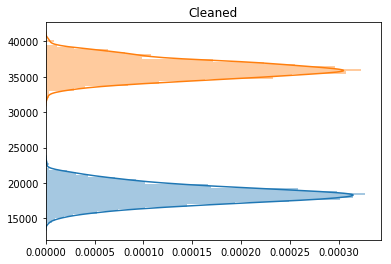

In [178]:
def mend_units(df, fix):
    # Visualizations
    np.random.seed(707)
    res = pd.Series([
        df['NoOfUnits'].sample(len(df), replace = True).sum() 
        for _ in range(1000)
    ])
    display(res.describe().apply(lambda x: format(x, 'f')))
    display(sns.distplot(res, vertical = True).set_title('Raw'))
    def clean_units(df):
        import numpy as np
        import pandas as pd
        data_dict = pd.read_excel('ZAsmt_DataDictionary_2016-01.xlsx', sheet_name='LandUse', header=5, usecols=np.arange(4))
        residential = data_dict[data_dict['Prefix Code Classification'].isin(['RI', 'RR'])]
        R = residential['StndCode']
        progress = np.linspace(0, 100, 7)[1:]
        print(str(round(progress[0], 2))+'%', 'current number:', df.NoOfUnits.sum())
        # Include only Residentials
        df = df[df['PropertyLandUseStndCode'].isin(R)]
        print(str(round(progress[1], 2))+'%', 'current number:', df.NoOfUnits.sum())
        medians = df.groupby('PropertyLandUseStndCode')['NoOfUnits'].median()
        import math
        if fix:
            def fix_units(r):
                code = r['PropertyLandUseStndCode']
                units = r['NoOfUnits']
                # return median if 0 or NaN
                #if units == 0.0 or math.isnan(units):
                    #return medians[code]

                #if code == 'RI104' and units < 5.0:
                    #return medians[code]
                #elif code == 'RI105' and units < 100.0:
                    #return medians[code]
                #elif code == 'RI106' and units < 5.0:
                    #return medians[code]
                if code == 'RI101': # duplex
                    return 2.0
                elif code == 'RI102': # triplex
                    return 3.0
                elif code == 'RI103': # quad
                    return 4.0

                return r['NoOfUnits']
            # Fix duplex, tri, quad, etc
            df['NoOfUnits'] = df.apply(fix_units, axis=1)
            # Records without this field seem to have inaccurate NoOfUnits
            df = df[pd.notnull(df['EffectiveYearBuilt'])]
        print(str(round(progress[3], 2))+'%', 'current number:', df.NoOfUnits.sum())
        # Fill nans with 1 for now
        value = {'NoOfUnits': 1}
        df.fillna(value=value, inplace=True)
        print(str(round(progress[4], 2))+'%', 'current number:', df.NoOfUnits.sum())
        # Fill 0's with 1 for now
        df = df.replace({'NoOfUnits': {0: 1}}) 
        print(str(round(progress[5], 2))+'%', 'current number:', df.NoOfUnits.sum())
        return df
    df = clean_units(df)

    # Visualizations
    np.random.seed(707)
    res2 = pd.Series([
        df['NoOfUnits'].sample(len(df), replace = True).sum() 
        for _ in range(1000)
    ])
    display(res2.describe().apply(lambda x: format(x, 'f')))
    display(sns.distplot(res2, vertical = True).set_title('Cleaned'))
    return df

# Only includes residential units
mv = mend_units(mv, fix = False)

# Round 1 (without NoOfUnits cleaning)

In [179]:
# Clean and filter for Mountain View JCE only
mv_jc = mv[mv['PropertyCity'] == 'MOUNTAIN VIEW']
print('Current number:', mv_jc.NoOfUnits.sum())

Current number: 36016.0


In [180]:
# Exempt- Single-family homes and condos, companion units, duplexes
mv_jc = mv_jc[~mv_jc['PropertyLandUseStndCode'].isin(['RR101', 'RR999', 'RR106', 'RI101'])]
print('Final number:', mv_jc.NoOfUnits.sum())

Final number: 17920.0


In [181]:
# Clean and filter for East Palo Alto Rent Control only
mv_rc = mv[mv['PropertyCity'] == 'MOUNTAIN VIEW']
print('Current number:', mv_rc.NoOfUnits.sum())

Current number: 36016.0


In [182]:
"""
# Units exempted from RC: units in hotels, motels, inns, tourist homes, 
# rooming, boarding houses, rental units in hospitals, convent, monastery, 
# extended medical care facility, asylum, non-profit home for the aged, government unit
"""
# ^ Already included in unit cleaning code when I only included residential units

# Must be 3 or more units
mv_rc = mv_rc[mv_rc['NoOfUnits'] >= 3]
print('Current number:', mv_rc.NoOfUnits.sum())

Current number: 16696.0


In [183]:
# Built before 1995
mv_rc = mv_rc[mv_rc['YearBuilt'] < 1995]
print('Current number:', mv_rc.NoOfUnits.sum())

Current number: 15578.0


In [184]:
mv_rc = mv_rc[~((mv_rc['OccupancyStatusStndCode'].isin(['O', 'I'])))]
print('Current number:', mv_rc.NoOfUnits.sum())

Current number: 14647.0


In [185]:
# Appropriate LandUseStndCodes and subtracting # of subsidized units
# Excludes Frats, dorms, duplexes, boarding houses, and mobile homes
r = ['RI000','RI102', 'RI103', 'RI104', 'RI105', 'RI106', 'RI107', 'RI112', 'RI114']
mv_rc = mv_rc[mv_rc['PropertyLandUseStndCode'].isin(r)]

round_1 = mv_rc.NoOfUnits.sum()
print('Final number:', round_1)

Final number: 14018.0


In [186]:
# check for oddities?
mv_rc[mv_rc['NoOfUnits'] == mv_rc['NoOfUnits'].max()]

,ImportParcelID,RowID,AssessorParcelNumber,PropertyFullStreetAddress,PropertyCity,PropertyState,PropertyZip,PropertyAddressLatitude,PropertyAddressLongitude,FIPS,PropertyZoningSourceCode,LotSizeSquareFeet,LotSizeAcres,RowID:1,PropertyCountyLandUseCode,PropertyLandUseStndCode,OccupancyStatusStndCode,YearBuilt,NoOfStories,NoOfUnits,TotalRooms,TotalBedrooms,TotalKitchens,TotalCalculatedBathCount,TotalActualBathCount,EffectiveYearBuilt,YearRemodeled,BuildingConditionStndCode,BuildingQualityStndCode,SewerStndCode,Address_Num,Address_Name,merge_row,Subsidized
9383,19700025,040F2C9C-2BD5-E511-80C1-3863BB43AC67,158-49-001,555 E MIDDLEFIELD RD,MOUNTAIN VIEW,CA,94043.0,37.395,-122.053,6085,NaN,632491.0,14.52,040F2C9C-2BD5-E511-80C1-3863BB43AC67,04,RI104,NaN,1969.0,3.0,402.0,0.0,0.0,NaN,0.0,NaN,1969.0,NaN,AV,NaN,NaN,555,E,9383,N


# Round 2 (with NoOfUnits cleaning)

(19444, 30)


count     1000.000000
mean     18326.119000
std       1312.485295
min      14363.000000
25%      17473.750000
50%      18307.500000
75%      19150.750000
max      22806.000000
dtype: object

Text(0.5,1,'Raw')

16.67% current number: 18385.0
33.33% current number: 18385.0
66.67% current number: 17782.0
83.33% current number: 17784.0
100.0% current number: 33274.0


count     1000.000000
mean     33275.618000
std       1263.762417
min      28825.000000
25%      32381.500000
50%      33257.500000
75%      34136.500000
max      37534.000000
dtype: object

Text(0.5,1,'Cleaned')

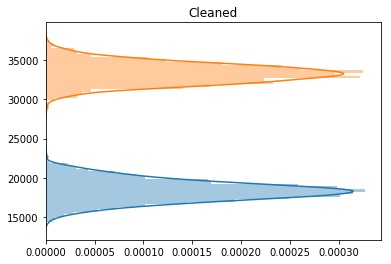

In [187]:
# Import Mountain Valley mv.csv
mv = pd.read_csv('mv.csv')

# ImportParcelID more accurate than APN
mv = mv.groupby('ImportParcelID', as_index = False).first()
print(mv.shape)

mv.head(2)

# Load CHPC which will help determine if property is subsidized
chpc = pd.read_excel('chpc.xls', sheet_name='Cleaned')

chpc.head(1)

# Cleaning so that we can properly join Ztrax and CHPC data
chpc['Address_Num'] = chpc['Address_Cleaned'].str.extract(r'(\d+)')
chpc['Address_Name'] = chpc['Address_Cleaned'].str.extract(r'([^\d,-]\w+)')
chpc['Address_Name'] = chpc['Address_Name'].str.upper()
#chpc.head(3)

# Cleaning again
mv['Address_Num'] = mv['PropertyFullStreetAddress'].str.extract(r'(\d+)')
mv['Address_Name'] = mv['PropertyFullStreetAddress'].str.extract(r'([^\d,-]\w+)')
mv['Address_Name'] = mv['Address_Name'].str.upper()
#epa.head(3)

# Merge based on euclidean distance
chpc = chpc.dropna(subset=['Longitude', 'Latitude'])
def merge_euclidean(table, chpc, eps=0.001):
    chpc_list = []
    table['merge_row'] = table.index.values
    for i, row in table.iterrows():
        chpc_subset = chpc.loc[((chpc.Longitude - row.PropertyAddressLongitude)**2 + (chpc.Latitude - row.PropertyAddressLatitude)**2 < eps) & (chpc.Address_Num == row.Address_Num) & (chpc.Address_Name == row.Address_Name)]
        chpc_subset['merge_row'] = i
        chpc_list.append(chpc_subset)
    chpc_found = pd.concat(chpc_list)

    result = pd.merge(table, chpc_found, on='merge_row', how='inner')
    return result

t = merge_euclidean(mv, chpc)

# These were the matches so attach 'Y' for subsidized
t['Subsidized'] = 'Y'
t.head(2)

# Rejoin with original epa table to identify subsidized units
t = t[['ImportParcelID', 'Subsidized']]
mv = pd.merge(mv, t, on='ImportParcelID', how='left')
mv.fillna(value={'Subsidized': 'N'}, inplace=True)
#mv.head()


mv[mv['Subsidized'] == 'Y']['NoOfUnits'].sum()

# Drop subsidized units
mv = mv[mv['Subsidized'] == 'N']
mv.shape

# Only includes residential units
mv = mend_units(mv, fix = True)

In [188]:
# Clean and filter for Mountain View JCE only
mv_jc = mv[mv['PropertyCity'] == 'MOUNTAIN VIEW']
print('Current number:', mv_jc.NoOfUnits.sum())

# Exempt- Single-family homes and condos, companion units, duplexes
mv_jc = mv_jc[~mv_jc['PropertyLandUseStndCode'].isin(['RR101', 'RR999', 'RR106', 'RI101'])]
print('Final number:', mv_jc.NoOfUnits.sum())

# Clean and filter for East Palo Alto Rent Control only
mv_rc = mv[mv['PropertyCity'] == 'MOUNTAIN VIEW']
print('Current number:', mv_rc.NoOfUnits.sum())

"""
# Units exempted from RC: units in hotels, motels, inns, tourist homes, 
# rooming, boarding houses, rental units in hospitals, convent, monastery, 
# extended medical care facility, asylum, non-profit home for the aged, government unit
"""
# ^ Already included in unit cleaning code when I only included residential units

# Must be 3 or more units
mv_rc = mv_rc[mv_rc['NoOfUnits'] >= 3]
print('Current number:', mv_rc.NoOfUnits.sum())

# Built before 1995
mv_rc = mv_rc[mv_rc['YearBuilt'] < 1995]
print('Current number:', mv_rc.NoOfUnits.sum())

mv_rc = mv_rc[~((mv_rc['OccupancyStatusStndCode'].isin(['O', 'I'])))]
print('Current number:', mv_rc.NoOfUnits.sum())

# Appropriate LandUseStndCodes and subtracting # of subsidized units
# Excludes Frats, dorms, duplexes, boarding houses, and mobile homes
r = ['RI000','RI102', 'RI103', 'RI104', 'RI105', 'RI106', 'RI107', 'RI112', 'RI114']
mv_rc = mv_rc[mv_rc['PropertyLandUseStndCode'].isin(r)]

round_2 = mv_rc.NoOfUnits.sum()
print('Final number:', round_2)


Current number: 33274.0
Final number: 16155.0
Current number: 33274.0
Current number: 16043.0
Current number: 14925.0
Current number: 14066.0
Final number: 13503.0


In [189]:
# Difference between the rounds
# Round 2 is much more accurate
err_round_1 = abs(13500 - round_1)
err_round_2 = abs(13500 - round_2)
print("Round 1 error:", err_round_1, "\nRound 2 error:", err_round_2)

Round 1 error: 518.0 
Round 2 error: 3.0
